In [1]:
## install imbalanced-learn if not installed
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install category_encoders --user

In [2]:
# check version number
import imblearn
import os
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from matplotlib import pyplot
import category_encoders as ce
from collections import Counter
print(imblearn.__version__)

0.8.0


# load dataset

In [3]:
%%time
data_dir = "/global/homes/z/zimingy/KE-Catboost/ziming/GO/data/go_aggregated_v3"
data_file = os.path.join(data_dir, 'go_aggregated_mixed_updated_normalized.pkl')
df = pd.read_pickle(data_file)
null_vals = df.isnull().sum(axis=0)
assert len(null_vals[null_vals != 0]) == 0
df

CPU times: user 5.32 s, sys: 1.07 s, total: 6.39 s
Wall time: 2.34 s


,id,study_id,sample_id,biome,exptype,version,GO:0043130,GO:0055074,GO:0055117,GO:0046933,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
19,ERZ650344,MGYS00003358,SRS3210273,root:Environmental:Aquatic:Marine:Brackish,assembly,4.1,0.001284,0.0,0.0,0.001645,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
27,ERZ747221,MGYS00004737,SRS1791943,root:Engineered:Biogas plant,assembly,4.1,0.020967,0.0,0.0,0.002165,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
29,ERZ761615,MGYS00003390,SRS1984850,root:Engineered:Bioreactor,assembly,4.1,0.000856,0.0,0.0,0.001299,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
30,ERR2193276,MGYS00005065,ERS2001073,root:Host-associated:Mammals,metagenomic,4.1,0.000000,0.0,0.0,0.000125,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
31,ERR2193277,MGYS00005065,ERS2001074,root:Host-associated:Mammals,metagenomic,4.1,0.000000,0.0,0.0,0.000149,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,ERZ1694525,MGYS00002035,ERS1030532,root:Environmental:Aquatic:Freshwater:Ice:Glacier,assembly,5.0,0.000000,0.0,0.0,0.000726,...,0.000000,0.000953,0.000185,0.0,0.000133,0.0,0.0,0.0,0.002308,0.001310
74274,ERZ1694526,MGYS00002035,ERS1030533,root:Environmental:Aquatic:Freshwater:Ice:Glacier,assembly,5.0,0.000000,0.0,0.0,0.000467,...,0.000000,0.000503,0.000000,0.0,0.000133,0.0,0.0,0.0,0.000860,0.000935
74275,ERZ1694527,MGYS00002035,ERS1030534,root:Environmental:Aquatic:Freshwater:Ice:Glacier,assembly,5.0,0.000428,0.0,0.0,0.000808,...,0.000000,0.001270,0.000000,0.0,0.000244,0.0,0.0,0.0,0.002353,0.002245
74276,ERZ1694528,MGYS00002035,ERS1030537,root:Environmental:Aquatic:Freshwater:Ice:Glacier,assembly,5.0,0.000428,0.0,0.0,0.000799,...,0.000000,0.001402,0.000000,0.0,0.000288,0.0,0.0,0.0,0.002081,0.002338


In [4]:
y = df.loc[:, 'biome']
X = df[df.columns[4:]]

## print biomes freq and bar plot

In [5]:
counter = Counter(y).most_common()
for k,v in counter:
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=root:Host-associated:Human:Digestive system:Large intestine:Fecal, n=17113 (46.599%)
Class=root:Host-associated:Human:Digestive system, n=4240 (11.546%)
Class=root:Host-associated:Human:Skin, n=3316 (9.030%)
Class=root:Mixed:Sediment:Sediment:Sediment, n=1993 (5.427%)
Class=root:Environmental:Aquatic:Marine, n=1426 (3.883%)
Class=root:Host-associated:Human:Digestive system:Large intestine, n=1266 (3.447%)
Class=root:Environmental:Aquatic:Marine:Oceanic, n=502 (1.367%)
Class=root:Host-associated:Animal:Digestive system:Fecal, n=478 (1.302%)
Class=root:Host-associated:Human:Digestive system:Oral:Saliva, n=429 (1.168%)
Class=root:Host-associated:Human:Digestive system:Large intestine:Sigmoid colon, n=400 (1.089%)
Class=root:Host-associated:Human:Digestive system:Intestine, n=390 (1.062%)
Class=root:Host-associated:Human:Digestive system:Oral, n=306 (0.833%)
Class=root:Engineered:Wastewater, n=306 (0.833%)
Class=root:Host-associated:Human, n=295 (0.803%)
Class=root:Host-associated:Bi

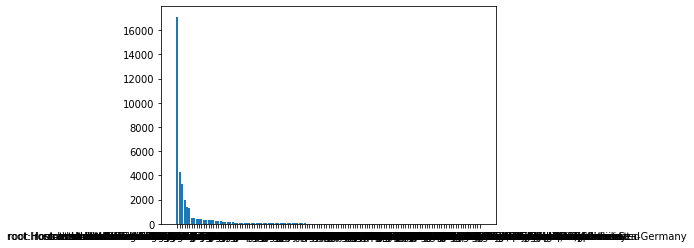

In [6]:
pyplot.bar(dict(counter).keys(), dict(counter).values())
pyplot.show()

In [7]:
## remove data with freq=1
low_freq_biome_names = []
for biome, freq in counter:
    if freq == 1:
        low_freq_biome_names.append(biome)

In [8]:
## get low freq biome indexes
low_freq_biome_indexes = df[df['biome'].isin(low_freq_biome_names)].index
## drop low freq biome samples
df_droped_low_freq_biomes = df.drop(low_freq_biome_indexes)
y_droped = df_droped_low_freq_biomes.loc[:, 'biome']
X_droped = df_droped_low_freq_biomes[df_droped_low_freq_biomes.columns[4:]]

In [9]:
X_droped

,exptype,version,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0007026,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
19,assembly,4.1,0.001284,0.0,0.0,0.001645,0.004742,0.000359,0.001137,0.0,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
27,assembly,4.1,0.020967,0.0,0.0,0.002165,0.009009,0.000020,0.002570,0.0,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
29,assembly,4.1,0.000856,0.0,0.0,0.001299,0.013751,0.001038,0.001264,0.0,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
30,metagenomic,4.1,0.000000,0.0,0.0,0.000125,0.000000,0.000180,0.000084,0.0,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
31,metagenomic,4.1,0.000000,0.0,0.0,0.000149,0.000000,0.000200,0.000126,0.0,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,assembly,5.0,0.000000,0.0,0.0,0.000726,0.000948,0.001338,0.000674,0.0,...,0.000000,0.000953,0.000185,0.0,0.000133,0.0,0.0,0.0,0.002308,0.001310
74274,assembly,5.0,0.000000,0.0,0.0,0.000467,0.000474,0.001098,0.000337,0.0,...,0.000000,0.000503,0.000000,0.0,0.000133,0.0,0.0,0.0,0.000860,0.000935
74275,assembly,5.0,0.000428,0.0,0.0,0.000808,0.002371,0.000639,0.001011,0.0,...,0.000000,0.001270,0.000000,0.0,0.000244,0.0,0.0,0.0,0.002353,0.002245
74276,assembly,5.0,0.000428,0.0,0.0,0.000799,0.003319,0.000879,0.000548,0.0,...,0.000000,0.001402,0.000000,0.0,0.000288,0.0,0.0,0.0,0.002081,0.002338


## Encode categarical features

In [10]:
set(X_droped['exptype'])

{'assembly', 'metagenomic'}

In [11]:
set(X_droped['version'])

{'4.1', '5.0'}

In [12]:
%%time
encoder= ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_droped)
X_encoded

CPU times: user 5.7 s, sys: 3.96 s, total: 9.66 s
Wall time: 302 ms


,exptype,version,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0007026,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
19,1,1,0.001284,0.0,0.0,0.001645,0.004742,0.000359,0.001137,0.0,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
27,1,1,0.020967,0.0,0.0,0.002165,0.009009,0.000020,0.002570,0.0,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
29,1,1,0.000856,0.0,0.0,0.001299,0.013751,0.001038,0.001264,0.0,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
30,2,1,0.000000,0.0,0.0,0.000125,0.000000,0.000180,0.000084,0.0,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
31,2,1,0.000000,0.0,0.0,0.000149,0.000000,0.000200,0.000126,0.0,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,1,2,0.000000,0.0,0.0,0.000726,0.000948,0.001338,0.000674,0.0,...,0.000000,0.000953,0.000185,0.0,0.000133,0.0,0.0,0.0,0.002308,0.001310
74274,1,2,0.000000,0.0,0.0,0.000467,0.000474,0.001098,0.000337,0.0,...,0.000000,0.000503,0.000000,0.0,0.000133,0.0,0.0,0.0,0.000860,0.000935
74275,1,2,0.000428,0.0,0.0,0.000808,0.002371,0.000639,0.001011,0.0,...,0.000000,0.001270,0.000000,0.0,0.000244,0.0,0.0,0.0,0.002353,0.002245
74276,1,2,0.000428,0.0,0.0,0.000799,0.003319,0.000879,0.000548,0.0,...,0.000000,0.001402,0.000000,0.0,0.000288,0.0,0.0,0.0,0.002081,0.002338


In [13]:
set(X_encoded['version'])

{1, 2}

In [14]:
set(X_encoded['exptype'])

{1, 2}

# Using SMOTE
Synthetic Minority Oversampling TEchnique, or SMOTE for short:
https://arxiv.org/abs/1106.1813

In [15]:
%%time
oversample = SMOTE(k_neighbors=1, random_state=0)
X_balanced, y_balanced = oversample.fit_resample(X_encoded, y_droped)

CPU times: user 32min 26s, sys: 7min 19s, total: 39min 46s
Wall time: 6min 12s


In [16]:
counter_balanced = Counter(y_balanced).most_common()
for k,v in counter_balanced:
    per = v / len(y_balanced) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=root:Environmental:Aquatic:Marine:Brackish, n=17113 (0.877%)
Class=root:Engineered:Biogas plant, n=17113 (0.877%)
Class=root:Engineered:Bioreactor, n=17113 (0.877%)
Class=root:Host-associated:Mammals, n=17113 (0.877%)
Class=root:Host-associated:Human:Digestive system:Large intestine:Fecal, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Marine:Intertidal zone:Estuary, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Thermal springs:Hot (42-90C), n=17113 (0.877%)
Class=root:Engineered:Solid waste:Composting, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Marine:Oceanic, n=17113 (0.877%)
Class=root:Host-associated:Microbial:Bacteria, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Freshwater:Groundwater, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Marine, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Freshwater:Lotic:Sediment, n=17113 (0.877%)
Class=root:Environmental:Aquatic:Estuary:Sediment, n=17113 (0.877%)
Class=root:Engineered:Wastewater:Water and sludge, n=1

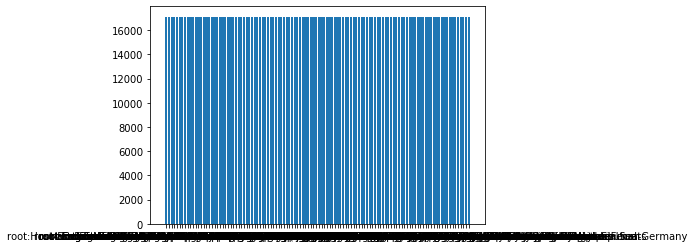

In [17]:
pyplot.bar(dict(counter_balanced).keys(), dict(counter_balanced).values())
pyplot.show()

In [19]:
X_balanced.insert(loc=0, column='biome', value=y_balanced)

In [20]:
X_balanced

,biome,exptype,version,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
0,root:Environmental:Aquatic:Marine:Brackish,1,1,0.001284,0.0,0.0,0.001645,0.004742,0.000359,0.001137,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
1,root:Engineered:Biogas plant,1,1,0.020967,0.0,0.0,0.002165,0.009009,0.000020,0.002570,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
2,root:Engineered:Bioreactor,1,1,0.000856,0.0,0.0,0.001299,0.013751,0.001038,0.001264,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
3,root:Host-associated:Mammals,2,1,0.000000,0.0,0.0,0.000125,0.000000,0.000180,0.000084,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
4,root:Host-associated:Mammals,2,1,0.000000,0.0,0.0,0.000149,0.000000,0.000200,0.000126,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950877,root:Mixed:Sediment:Sediment:Sediment,2,1,0.014171,0.0,0.0,0.007368,0.000000,0.000541,0.005443,...,0.000000,0.008825,0.003778,0.0,0.001968,0.0,0.0,0.0,0.021202,0.019062
1950878,root:Mixed:Sediment:Sediment:Sediment,2,1,0.000268,0.0,0.0,0.010051,0.000177,0.000549,0.009403,...,0.000000,0.005461,0.000983,0.0,0.000504,0.0,0.0,0.0,0.045567,0.015041
1950879,root:Mixed:Sediment:Sediment:Sediment,2,1,0.000000,0.0,0.0,0.015304,0.000000,0.003885,0.016863,...,0.000000,0.008111,0.000687,0.0,0.001775,0.0,0.0,0.0,0.045126,0.043989
1950880,root:Mixed:Sediment:Sediment:Sediment,2,1,0.000428,0.0,0.0,0.008806,0.000914,0.000581,0.006588,...,0.000000,0.007069,0.001405,0.0,0.001375,0.0,0.0,0.0,0.037848,0.013259


In [22]:
X_balanced.to_pickle(os.path.join(data_dir, 'go_aggregated_mixed_updated_normalized_oversampled.pkl'))